## Comparison between the stability of the 3 geodesic shootings schemes proposed for LDDMM



You can open your pictures here. 

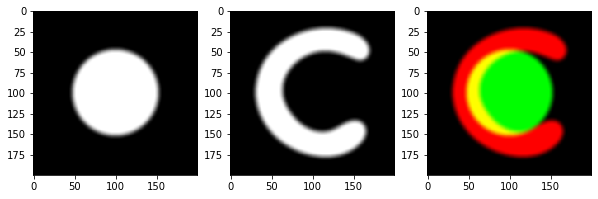

In [2]:
import torch
#from torch.utils.checkpoint import checkpoint # redondant mais necéssaire ...
import kornia.filters as flt
import matplotlib.pyplot as plt
import time
from math import log

from my_toolbox import update_progress,format_time
import my_torchbox as tb
import vector_field_to_flow as vff
import metamorphosis as mt

#Picture Opening
plt.rcParams['figure.figsize'] = [10,20]
size = (200,200) # You can set the size here, put None if you want to use the original size
S = tb.reg_open('08',size = size) 
T = tb.reg_open('m0',size = size) 
if size is None:
    _,_,H,W = S.shape
    size = (H,W)
else:
    H,W = size

# To blur the pictures with a gaussian kernel of sigma = 3
sig = 3
smooth = flt.GaussianBlur2d((sig*3,sig*3), (sig, sig))
S = smooth(S)
T = smooth(T)



id_grid = tb.make_regular_grid(size)
field = id_grid.clone()

# You can try different initial residuals 

residuals = torch.zeros(size)
# # the difference of the source and target image is an interesting initialisation
# residuals = (T - S)[0,0,:,:]
# # to start over with a already initialized residual.
# # residuals = mr_1.to_analyse[0]
residuals.requires_grad = True
residuals.to('cuda:0')

# Show the pictures open
plt.rcParams['figure.figsize'] = [10,30]
fig,ax = plt.subplots(1,3)
ax[0].imshow(S[0,0,:,:],cmap='gray',vmin=0,vmax=1)
ax[1].imshow(T[0,0,:,:],cmap='gray',vmin=0,vmax=1)
ax[2].imshow(tb.imCmp(S,T),vmin=0,vmax=1)
plt.show()

To prepare the figure, in the article we decided to use a well chosen initial $z$ to demonstrate the shootings.
 To do so we ran the optimisation process. Theses cells are for this purpose.

You can run the optimisation by yourself, or load the result in the next cell if you don't want to wait for the optimisation to finish. (Loading works only for the example we provide) 

Percent: [##########] 100% Done...99999%  
time  0:00:23s and 0.560cents

 time for plot ============ 
plot 1  0:00:00s and 0.017cents
plot 2  0:00:00s and 0.054cents
plot 3  0:00:00s and 0.054cents
field_stock  torch.Size([20, 200, 200, 2])


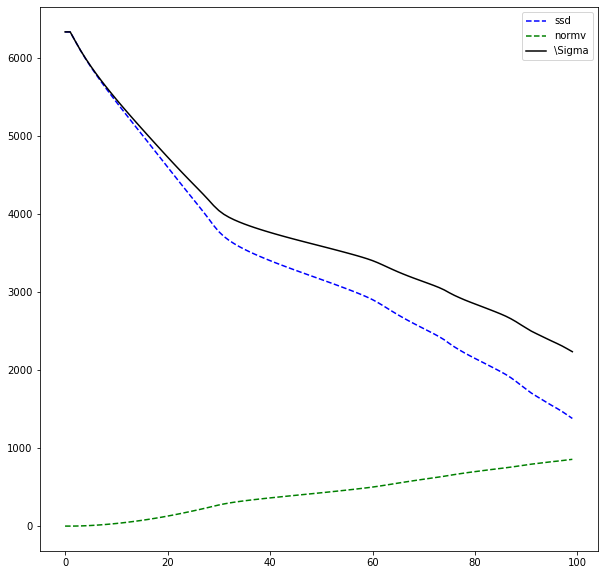

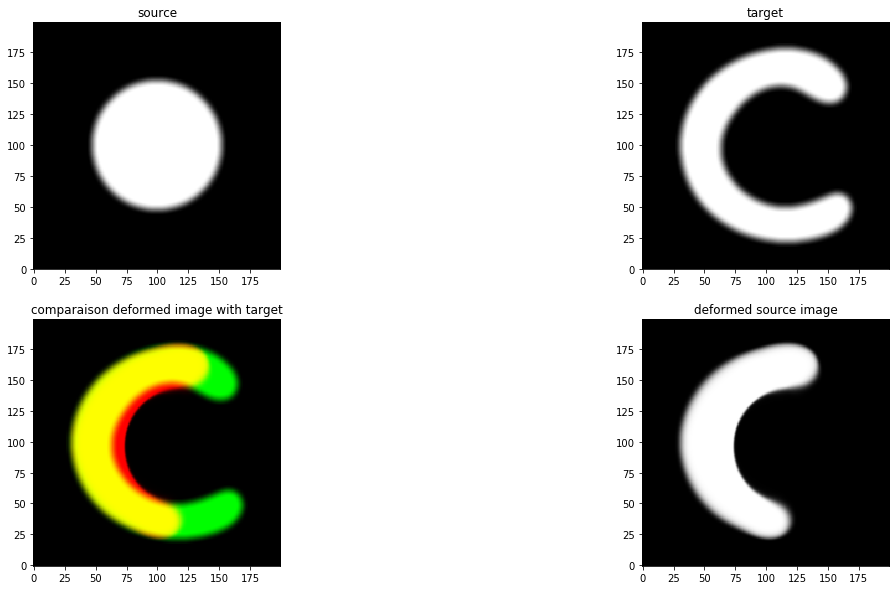

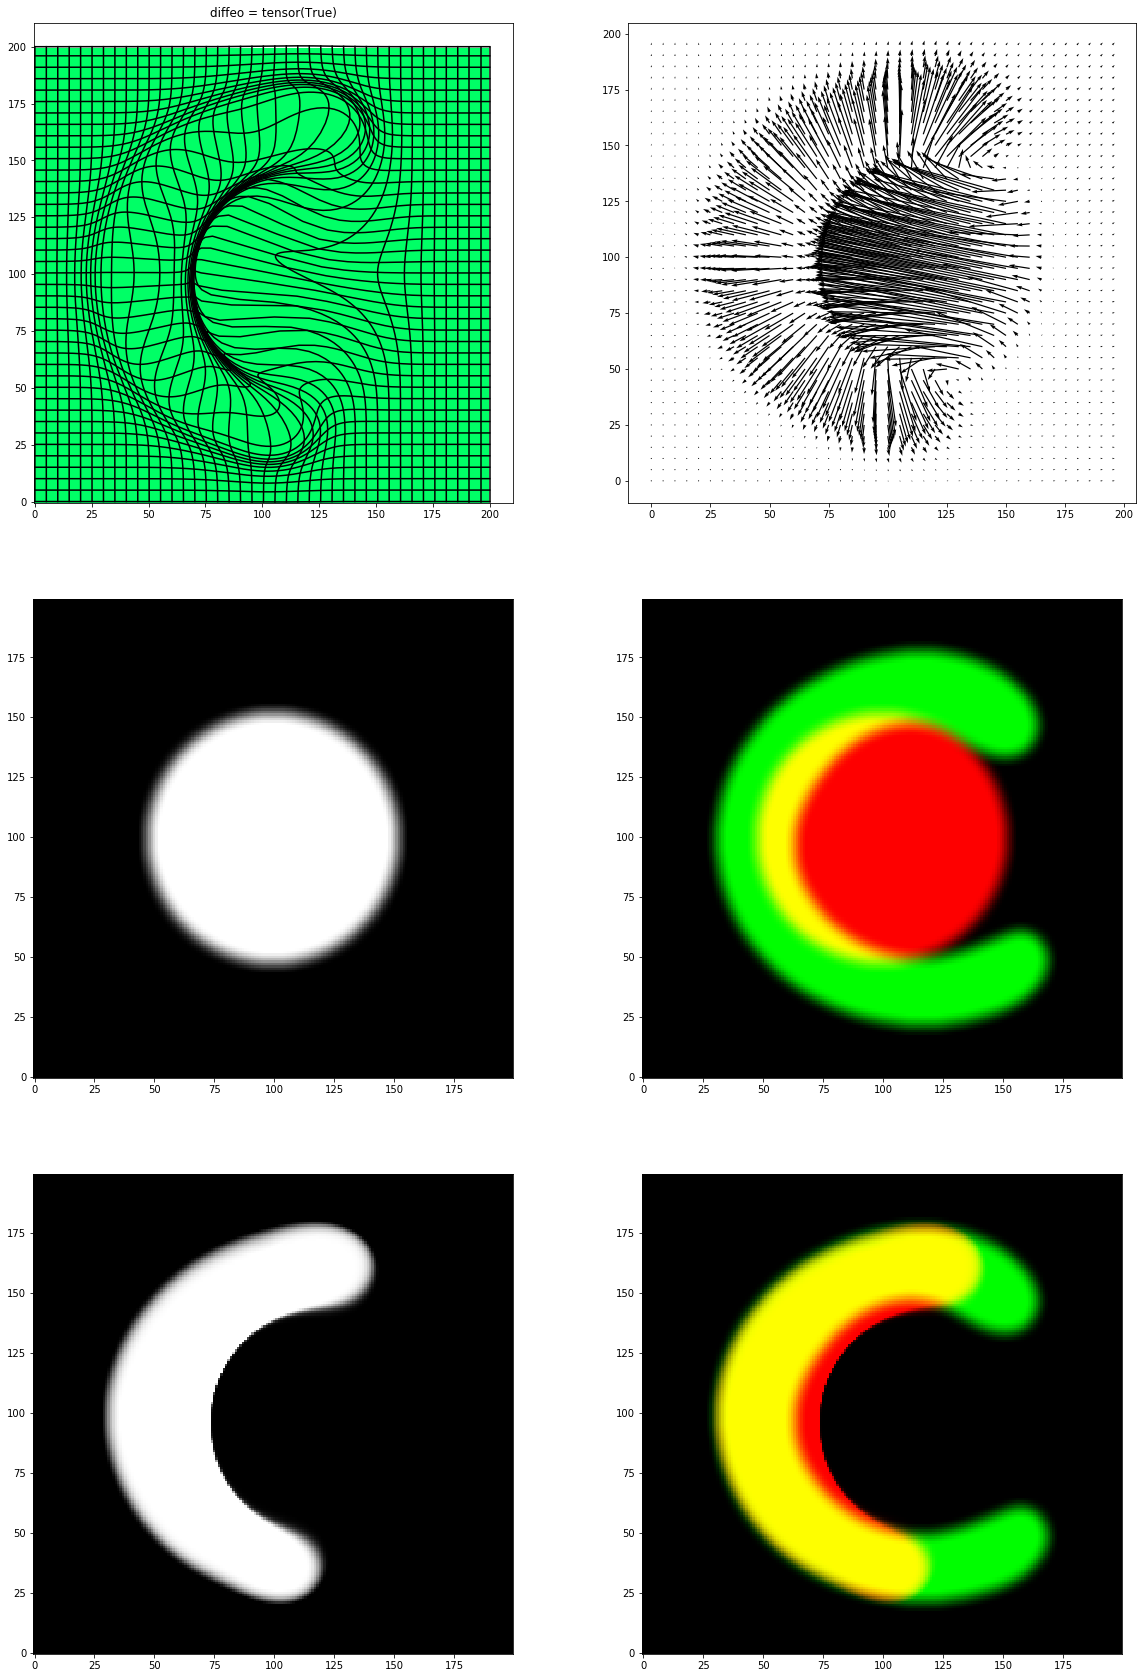

In [3]:
lamb = 1e-4
n_iter = 100

start = time.time()
# Initialisation of the geodesic shooting method
mp_L = mt.metamorphosis_path(method ='semiLagrangian',mu=0,sigma_v=10,n_step=20)
# Initialisation of the Demeter method
mr_L = mt.grad_descent_metamorphosis(S,T,mp_L,cost_l=lamb,grad_dt= 10000)
# Optimisation
mr_L.forward(residuals,n_iter=n_iter,verbose=True)
end = time.time()

print('time ',format_time(end - start))
# Show results
mr_L.plot()
mr_L.plot_deform()


The chosen initial residual is :

[]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


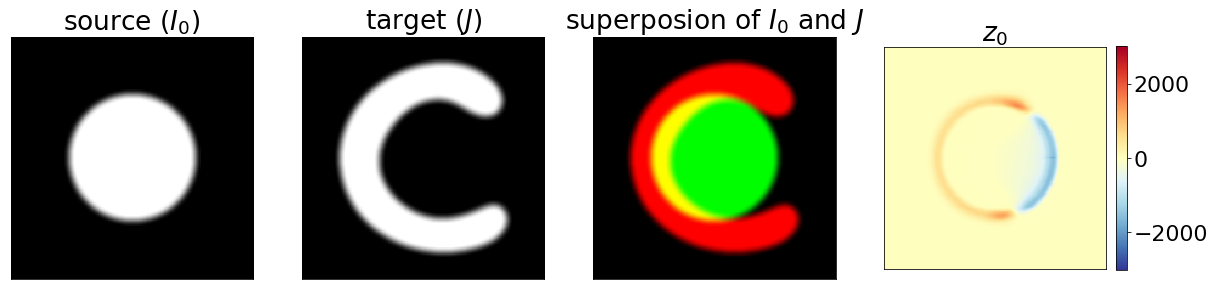

In [4]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 22})

residuals = mr_L.to_analyse[0]
residuals.requires_grad = True
residuals.to('cuda')

kw_image_args = dict(cmap='gray',
                      extent=[-1,1,-1,1],
                      origin='lower',
                      vmin=0,vmax=1)
kw_residuals_args = dict(cmap='RdYlBu_r',
                      extent=[-1,1,-1,1],
                      origin='lower',
                      vmin=-3000,vmax=3000,   )

fig,ax = plt.subplots(1,4)
ax[0].imshow(S[0,0,:,:],**kw_image_args)
ax[0].set_title(r'source ($I_0$)')

ax[1].imshow(T[0,0,:,:],**kw_image_args)
ax[1].set_title(r'target ($J$)')

ax[2].imshow(tb.imCmp(S,T),**kw_image_args)
ax[2].set_title(r'superposion of $I_0$ and $J$')

r_ini =ax[3].imshow(residuals.detach(),**kw_residuals_args)
fig.colorbar(r_ini,ax=ax[3],
        fraction=0.046, pad=0.04)
ax[3].set_title(r'$z_0$')
plt.setp(ax, xticks=[], yticks=[])


In [5]:
mu = 0
sigma_v=10

# set plot to a positive integer to see geodesic integrations
plot = 0

start = time.time()
mp_E = mt.metamorphosis_path(method='Eulerian',mu=mu,sigma_v=sigma_v,n_step=150)
mp_E.forward(S.clone(),field.clone(),residuals.clone(),plot=plot)
end = time.time()

In [6]:
start = time.time()
mp_aL = mt.metamorphosis_path(method='advection_semiLagrangian',mu=mu,sigma_v=sigma_v,n_step=20)
mp_aL.forward(S.clone(),field.clone(),residuals.clone(),plot=plot)
end = time.time()

start = time.time()
mp_L = mt.metamorphosis_path(method='semiLagrangian',mu=mu,sigma_v=sigma_v,n_step=20)
mp_L.forward(S.clone(),field.clone(),residuals.clone(),plot=plot)
end = time.time()


temporal_integrator = vff.FieldIntegrator(method='temporal',
                                            save=False,
                                            dx_convention='pixel')

E_deformation = temporal_integrator(mp_E.field_stock/mp_E.n_step,forward=True)
aL_deformation = temporal_integrator(mp_aL.field_stock/mp_aL.n_step,forward=True)
L_deformation = temporal_integrator(mp_L.field_stock/mp_L.n_step,forward=True)

The figure as it is computed here present some instabilities, try increasing n_step 

[]

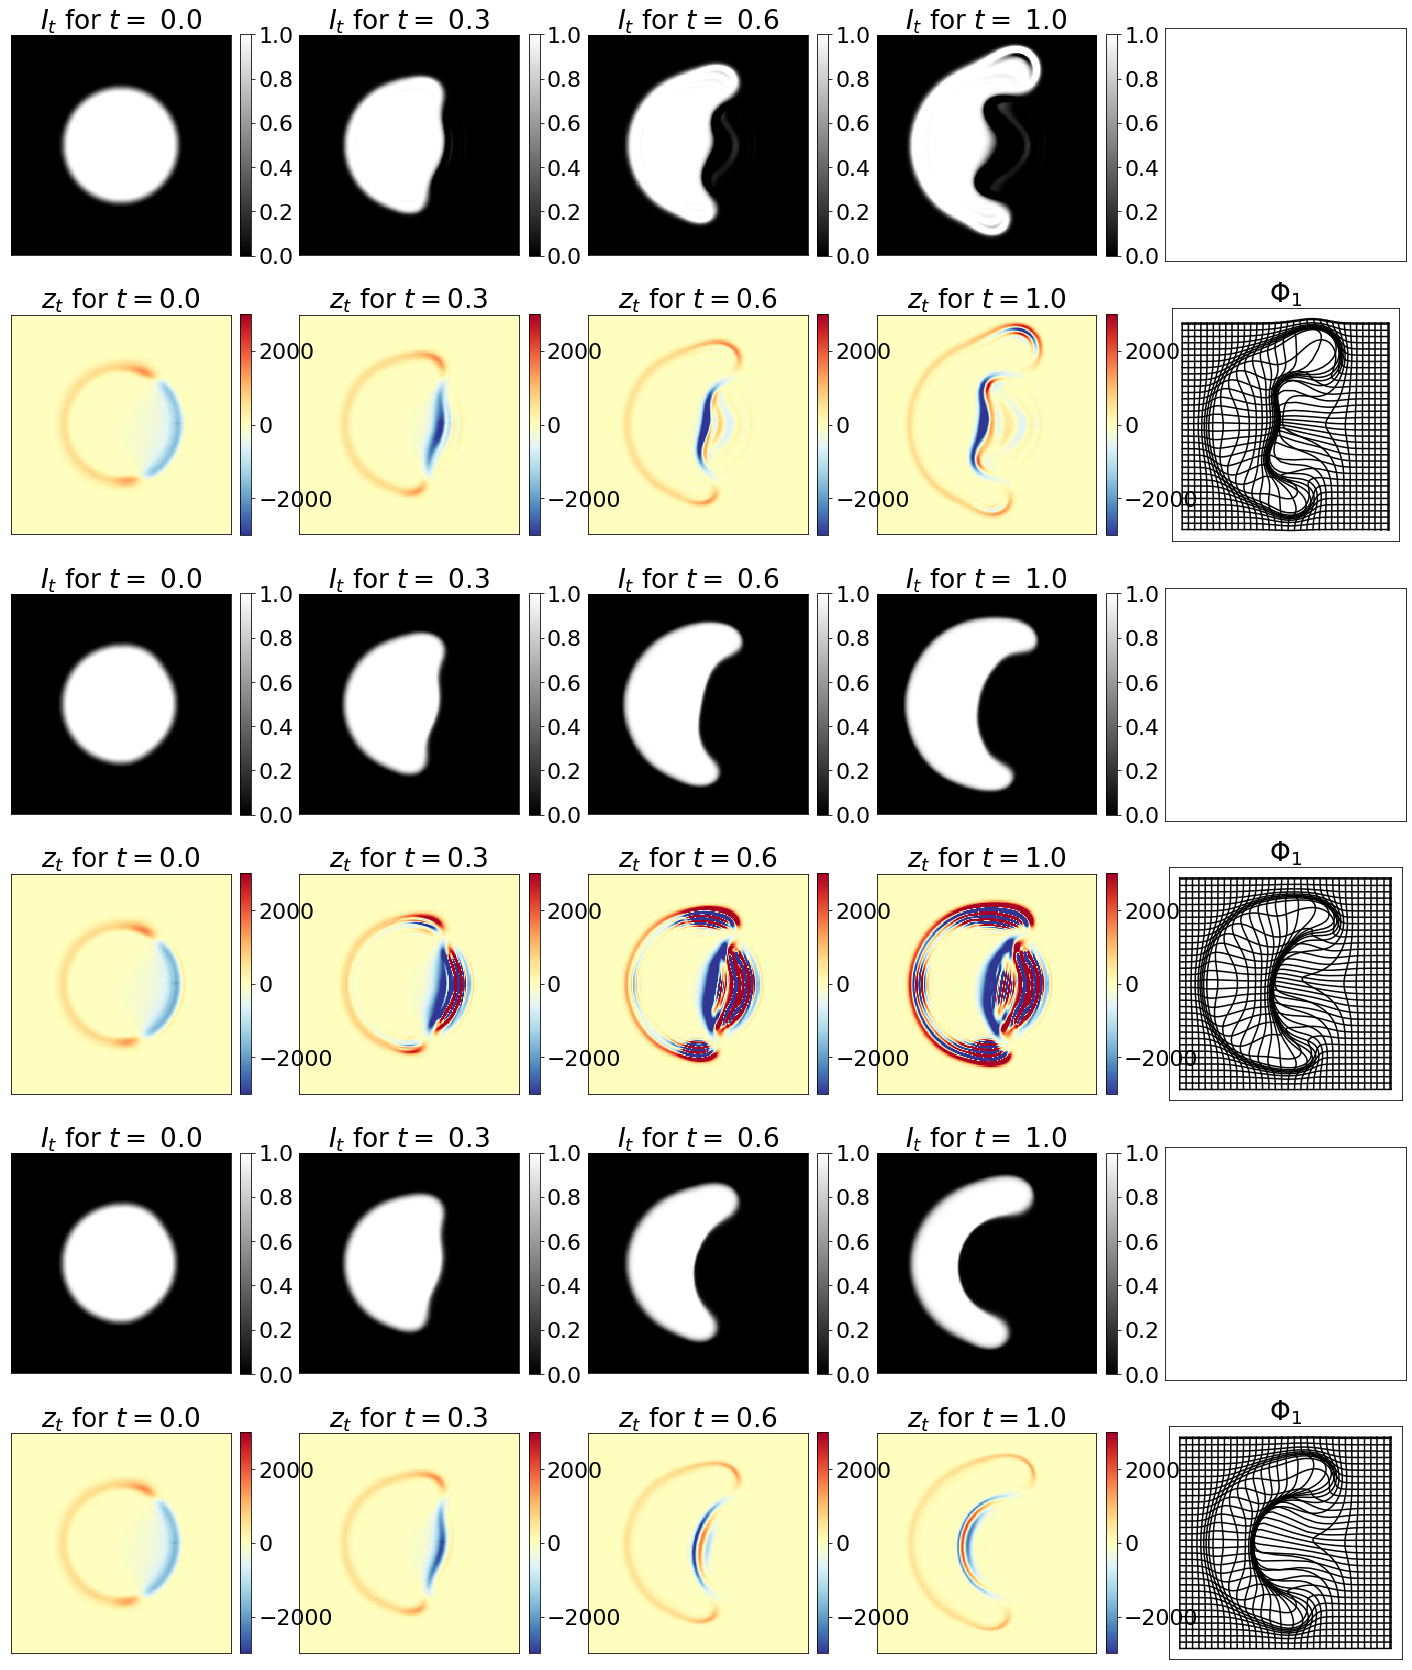

In [7]:
plot_id = torch.quantile(torch.arange(mp_L.n_step,dtype=torch.float),
                                 torch.linspace(0,1,4)).round().int()
# plot_id= plot_id[1:]
plot_id_E = torch.quantile(torch.arange(mp_E.n_step,dtype=torch.float),
                                 torch.linspace(0,1,4)).round().int()
# plot_id_E= plot_id_E[1:]

size_fig = 5
step = int(min(mp_E.field_stock.shape[2:-1])/30)
plt.rcParams['figure.figsize'] = [size_fig*5,6*size_fig]
fig_me,ax_me = plt.subplots(6,5)

for i,t in enumerate(plot_id_E):
    i_1 =ax_me[0,i].imshow(mp_E.image_stock[t,0,:,:].detach().numpy(),
            **kw_image_args)
    ax_me[0,i].set_title(r"$I_t$ for $t =$ "+str((t/(mp_E.n_step-1)).item())[:3])
    fig_me.colorbar(i_1,ax=ax_me[0,i],fraction=0.046, pad=0.04)

    r_1 =ax_me[1,i].imshow(mp_E.residuals_stock[t,:,:].detach().numpy(),
            **kw_residuals_args)
    ax_me[1,i].set_title(r"$z_t$ for $t = $"+str((t/(mp_E.n_step-1)).item())[:3])
    fig_me.colorbar(r_1,ax=ax_me[1,i],fraction=0.046, pad=0.04)

# ax_me[0,-1].imshow(tb.imCmp(mp_E.image,T))
# ax_me[0,-1].set_title(r"Comparaison $I_1$ vs $J$")



tb.gridDef_plot(E_deformation,ax = ax_me[1,-1],step=step, dx_convention='pixel')
ax_me[1,-1].set_title(r"$\Phi_1$")

for i,t in enumerate(plot_id):
    i_2 =ax_me[2,i].imshow(mp_aL.image_stock[t,0,:,:].detach().numpy(),
            **kw_image_args)
    ax_me[2,i].set_title(r"$I_t$ for $t =$ "+str((t/(mp_aL.n_step-1)).item())[:3])
    fig_me.colorbar(i_2,ax=ax_me[2,i],fraction=0.046, pad=0.04)

    r_2 =ax_me[3,i].imshow(mp_aL.residuals_stock[t,:,:].detach().numpy(),
            **kw_residuals_args)
    ax_me[3,i].set_title(r"$z_t$ for $t = $"+str((t/(mp_aL.n_step-1)).item())[:3])
    fig_me.colorbar(r_2,ax=ax_me[3,i],fraction=0.046, pad=0.04)

    i_3 =ax_me[4,i].imshow(mp_L.image_stock[t,0,:,:].detach().numpy(),
            **kw_image_args)
    ax_me[4,i].set_title(r"$I_t$ for $t =$ "+str((t/(mp_aL.n_step-1)).item())[:3])
    fig_me.colorbar(i_3,ax=ax_me[4,i],fraction=0.046, pad=0.04)

    r_3 =ax_me[5,i].imshow(mp_L.residuals_stock[t,:,:].detach().numpy(),
            **kw_residuals_args)
    ax_me[5,i].set_title(r"$z_t$ for $t = $"+str((t/(mp_L.n_step-1)).item())[:3])
    fig_me.colorbar(r_3,ax=ax_me[5,i],fraction=0.046, pad=0.04)

# ax_me[2,-1].imshow(tb.imCmp(mp_aL.image,T))
# ax_me[2,-1].set_title(r"Comparaison $I_1$ vs J")
tb.gridDef_plot(aL_deformation,ax = ax_me[3,-1],step=step, dx_convention='pixel')
ax_me[3,-1].set_title(r"$\Phi_1$")

# ax_me[4,-1].imshow(tb.imCmp(mp_L.image,T))
# ax_me[4,-1].set_title(r"Comparaison $I_1$ vs T")
tb.gridDef_plot(L_deformation,ax = ax_me[5,-1],step=step, dx_convention='pixel')
ax_me[5,-1].set_title(r"$\Phi_1$")

plt.setp(ax_me, xticks=[], yticks=[])